# TensorFlow 2.0

In [1]:
from glob import glob

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('./dataset/cifar/train/*.png')
test_paths = glob('./dataset/cifar/test/*.png')

In [6]:
train_paths[0]

'./dataset/cifar/train/23927_frog.png'

In [7]:
path = train_paths[0]
path

'./dataset/cifar/train/23927_frog.png'

In [8]:
def get_class_name(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    return lbl_name

In [9]:
path, get_class_name(path)

('./dataset/cifar/train/23927_frog.png',
 <tf.Tensor: id=413, shape=(), dtype=string, numpy=b'frog'>)

In [10]:
class_names = [get_class_name(path) for path in train_paths]
class_names[:10]

[<tf.Tensor: id=477, shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: id=541, shape=(), dtype=string, numpy=b'deer'>,
 <tf.Tensor: id=605, shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: id=669, shape=(), dtype=string, numpy=b'dog'>,
 <tf.Tensor: id=733, shape=(), dtype=string, numpy=b'bird'>,
 <tf.Tensor: id=797, shape=(), dtype=string, numpy=b'bird'>,
 <tf.Tensor: id=861, shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: id=925, shape=(), dtype=string, numpy=b'dog'>,
 <tf.Tensor: id=989, shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: id=1053, shape=(), dtype=string, numpy=b'frog'>]

In [12]:
classes = tf.unique(class_names).y.numpy()
classes

array([b'frog', b'deer', b'cat', b'dog', b'bird', b'airplane',
       b'automobile', b'truck', b'ship', b'horse'], dtype=object)

In [13]:
classes == get_class_name(path)

<tf.Tensor: id=3200482, shape=(10,), dtype=bool, numpy=
array([ True, False, False, False, False, False, False, False, False,
       False])>

In [16]:
onehot = tf.cast(classes == get_class_name(path), tf.uint8)
onehot

<tf.Tensor: id=3200683, shape=(10,), dtype=uint8, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)>

In [17]:
def onehot_encoding(label_name):
    onehot = tf.cast(classes == label_name, tf.uint8)
    return onehot

In [31]:
def read_dataset(path):
    # read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    # Normalize image
    image = tf.cast(image, tf.float32) / 255.
    
    # read label
    class_name = get_class_name(path)
    label = onehot_encoding(class_name)
    return image, label

In [20]:
image, label = read_dataset(path)

In [21]:
image.shape, label.shape

(TensorShape([32, 32, 3]), TensorShape([10]))

In [22]:
def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [25]:
transformed, label = image_preprocess(image, label)

In [26]:
transformed.shape

TensorShape([32, 32, 3])

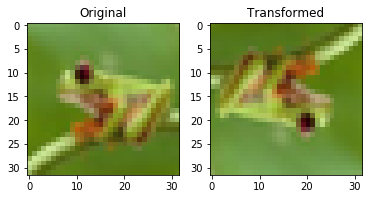

In [28]:
plt.subplot(121)
plt.title('Original')
plt.imshow(image)

plt.subplot(122)
plt.title('Transformed')
plt.imshow(transformed)

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(read_dataset)
# Transform image
train_dataset = train_dataset.map(image_preprocess)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [33]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(read_dataset)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=len(test_paths))
test_dataset = test_dataset.repeat()

## Training

In [36]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

In [37]:
model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps = validation_steps,
    epochs=num_epochs,
)

Epoch 1/10
1562/1562 [==============================] - 48s 31ms/step - loss: 1.6981 - accuracy: 0.3647 - val_loss: 1.4213 - val_accuracy: 0.4721
Epoch 2/10
1562/1562 [==============================] - 46s 29ms/step - loss: 1.4197 - accuracy: 0.4790 - val_loss: 1.2810 - val_accuracy: 0.5394
Epoch 3/10
1562/1562 [==============================] - 43s 28ms/step - loss: 1.3126 - accuracy: 0.5228 - val_loss: 1.1598 - val_accuracy: 0.5806
Epoch 4/10
1562/1562 [==============================] - 44s 28ms/step - loss: 1.2420 - accuracy: 0.5495 - val_loss: 1.1896 - val_accuracy: 0.5782
Epoch 5/10
1562/1562 [==============================] - 44s 28ms/step - loss: 1.1850 - accuracy: 0.5733 - val_loss: 1.0427 - val_accuracy: 0.6309
Epoch 6/10
1562/1562 [==============================] - 44s 28ms/step - loss: 1.1511 - accuracy: 0.5893 - val_loss: 1.0802 - val_accuracy: 0.6079
Epoch 7/10
1562/1562 [==============================] - 43s 28ms/step - loss: 1.1210 - accuracy: 0.5985 - val_loss: 0.9669 -